In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
# !cp drive/MyDrive/MMDS-data/spark-3.1.1-bin-hadoop3.2.tgz .
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [2]:
import os
import shutil
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

In [3]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=19d82a62ddcf5968b071950de4e7576e5547e6189eba6227239e313b40a666c6
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [4]:
import findspark
findspark.init()

In [79]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sha2, row_number, lit, concat_ws, concat
from pyspark.sql.types import StructType, StructField, IntegerType, StringType
from pyspark.sql.window import Window

# Khởi tạo SparkSession
spark = SparkSession.builder \
    .appName("LSH Example") \
    .getOrCreate()

# Dữ liệu chữ ký mẫu
data = [
    (2, 4, 3, 2, 1, 3),
    (4, 2, 1, 3, 5, 1),
    (3, 4, 2, 1, 3, 2),
    (1, 1, 3, 4, 2, 5),
    (24, 3, 3, 8, 1, 3),
    (34, 5, 1, 7, 5, 1),
    (32, 6, 2, 8, 3, 2),
    (11, 7, 3, 9, 2, 5)
]

# Định nghĩa schema cho DataFrame
schema = StructType([
    StructField("0", IntegerType(), True),
    StructField("1", IntegerType(), True),
    StructField("2", IntegerType(), True),
    StructField("3", IntegerType(), True),
    StructField("4", IntegerType(), True),
    StructField("5", IntegerType(), True)
])

# Tạo DataFrame từ dữ liệu và schema
df = spark.createDataFrame(data, schema)
df.show()
# Số lượng bands
num_bands = 4

# Thêm cột chỉ mục hàng
df_with_index = df.withColumn("row_index", row_number().over(Window.orderBy("1")))

# Chia DataFrame thành các band dựa trên chỉ mục hàng
band_size = len(data) // num_bands
banded_dfs = []

for i in range(num_bands):
    start_index = i * band_size + 1
    end_index = (i + 1) * band_size

    band_df = df_with_index.filter((col("row_index") >= start_index) & (col("row_index") <= end_index)).drop("row_index")
    banded_dfs.append(band_df)

# Tạo DataFrame mới để lưu trữ hash values
hashed_dfs = []
all_hashed_df = spark.createDataFrame([], schema=StructType([
    StructField("signature", StringType(), True),
    StructField("bucket-id", StringType(), True)
]))
all_hashed_df.show()
# Hash giá trị của các hàng của từng cột trong mỗi band và lưu vào DataFrame mới
for i, band_df in enumerate(banded_dfs, 1):
    # Hash giá trị của các hàng của từng cột
    for col_name in band_df.columns:
        # Tạo cột hash
        doc1_concatenated = band_df.select(concat(col_name).alias("concatenated_doc1"))
        # Thu thập tất cả các giá trị của cột đã nối thành một danh sách
        concatenated_values_list = [str(row["concatenated_doc1"]) for row in doc1_concatenated.collect()]

        # Nối tất cả các giá trị trong danh sách lại với nhau thành một chuỗi
        concatenated_values = "-".join(concatenated_values_list)
        # Chuyển đổi chuỗi thành một literal column bằng cách sử dụng hàm lit()
        concatenated_values_lit = lit(concatenated_values).alias("concatenated_values")

        # Hash chuỗi đã nối bằng sha2 với độ dài 256-bit
        hashed_doc1 = sha2(concatenated_values_lit.cast("string"), 256).alias("hashed_doc1")

        hashed_df = spark.createDataFrame([(col_name,)], ["signature"])
        hashed_df = hashed_df.withColumn("bucket-id", hashed_doc1)
        all_hashed_df =all_hashed_df.union(hashed_df)

        # Hiển thị DataFrame mới
        # hashed_df.show(truncate=False)
grouped_df = all_hashed_df.groupBy("bucket-id").agg(collect_list("signature").alias("signature"))

# Show the grouped DataFrame
grouped_df.show(truncate=False)

+---+---+---+---+---+---+
|  0|  1|  2|  3|  4|  5|
+---+---+---+---+---+---+
|  2|  4|  3|  2|  1|  3|
|  4|  2|  1|  3|  5|  1|
|  3|  4|  2|  1|  3|  2|
|  1|  1|  3|  4|  2|  5|
| 24|  3|  3|  8|  1|  3|
| 34|  5|  1|  7|  5|  1|
| 32|  6|  2|  8|  3|  2|
| 11|  7|  3|  9|  2|  5|
+---+---+---+---+---+---+

+---------+---------+
|signature|bucket-id|
+---------+---------+
+---------+---------+

+----------------------------------------------------------------+---------+
|bucket-id                                                       |signature|
+----------------------------------------------------------------+---------+
|3791968fee79a54bfcf3e65ea4a6aeef457df5c254e7b9ba433e1980dec6e6e2|[3]      |
|1ba709d2440f09ecbfe6754a83ce9e22e51146297ac904d002d5ba01645fa6ed|[4]      |
|16c4b6b5193bba56c91d416c98ee42ca1261bb7bf86959b3d74d98b3308154db|[3]      |
|0bf18b49509506f814906149d29506605c10bce69d33276b3bf4d95290915061|[1]      |
|e2433ac3278279ac90b51abed3d4dd9057d9e1f66541ad9cdfd13762a3

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import csv
from pyspark import SparkContext
from pyspark.conf import SparkConf
from collections import OrderedDict
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
csv_path = "/content/drive/MyDrive/Midterm_BigData/baskets.csv"

In [ ]:
app = 'exampleRDDApi'

# Spark context configurations
conf = (SparkConf().setAppName(app)
                    .setMaster("local[*]")
                    .set('spark.driver.maxResultSize', '8g')
                    .set('spark.logConf', 'true'))
sparkContext = SparkContext(conf=conf)

In [ ]:
# Load CSV into a RDD
rdd = sparkContext.textFile(csv_path)
# Count all records of df
print("Number of Row - Data: " ,rdd.count())
header = rdd.first()
rdd = rdd.filter(lambda line: line != header)
# Phân tách dữ liệu
rdd_split = rdd.map(lambda line: line.split(","))

Number of Row - Data:  38766


# QUESTION 1

#F1

In [ ]:
def f1(path):

  # Lấy cột itemDescription và loại bỏ các giá trị trùng lặp
  distinct_items_rdd = rdd_split.map(lambda x: x[2]).distinct()

  # Sắp xếp các món hàng theo thứ tự tăng dần theo tên
  sorted_items_rdd = distinct_items_rdd.sortBy(lambda item: item)

  # print(sorted_original_items_rdd.take(sorted_original_items_rdd.count()))
  sorted_items_rdd.coalesce(1).saveAsTextFile("f1")
  print10F1(sorted_items_rdd)

def print10F1(df):
  top_10_items = df.take(10)
  # In ra kết quả
  print("Top 10 distinct items:")
  for item in top_10_items:
      print(item)


  num_distinct_items = df.count()
  # Lấy 10 món hàng cuối cùng
  bottom_10_items = df.take(num_distinct_items)[-10:] # collect -> top
  # In ra 10 món hàng cuối cùng
  print("\nBottom 10 items:")
  for item in bottom_10_items:
      print(item)

In [ ]:
f1(csv_path)

Top 10 distinct items:
Instant food products
UHT-milk
abrasive cleaner
artif. sweetener
baby cosmetics
bags
baking powder
bathroom cleaner
beef
berries

Bottom 10 items:
turkey
vinegar
waffles
whipped/sour cream
whisky
white bread
white wine
whole milk
yogurt
zwieback


#F2

In [ ]:
def f2(path):

  # Đếm số lần mỗi món hàng được mua, (key, value) (trích xuất từ phần tử thứ ba của mỗi bản ghi), và value là 1 (biểu thị cho một lần mua)., gộp và đếm value
  item_counts = rdd_split.map(lambda x: (x[2], 1)).reduceByKey(lambda a, b: a + b)

  # Sắp xếp giảm dần theo số lần được mua
  sorted_items_counts = item_counts.sortBy(lambda x: x[1], ascending=False)

  top_100_items = sorted_items_counts.take(100)
  sorted_items_counts.coalesce(1).saveAsTextFile("f2")
  print("Top 100 món hàng được mua nhiều nhất:")
  for item, count in top_100_items:
      print(f"{item}: {count}")

  return top_100_items

def visualizationData_(top_100_items):

  # Tạo danh sách tên món hàng và số lần mua tương ứng
  item_names = [item[0] for item in top_100_items]
  item_purchase_counts = [item[1] for item in top_100_items]

  # Vẽ biểu đồ cột
  plt.figure(figsize=(20,25))
  plt.barh(item_names, item_purchase_counts, color='skyblue')
  plt.xlabel('Số lần mua')
  plt.ylabel('Món hàng')
  plt.title('Top 100 món hàng được mua nhiều nhất')
  plt.gca().invert_yaxis()
  plt.show()

def visualizationData(top_100_items):

  top_10_items = top_100_items[:10]

  item_names_top_10 = [item[0] for item in top_10_items]
  item_purchase_counts_top_10 = [item[1] for item in top_10_items]

  plt.figure(figsize=(10, 10))
  plt.pie(item_purchase_counts_top_10, labels=item_names_top_10, autopct='%1.1f%%', startangle=140)
  plt.title('Top 10 món hàng được mua nhiều nhất')
  plt.axis('equal')
  plt.show()


In [ ]:
dataf2 = f2("/content/drive/MyDrive/Midterm_BigData/baskets.csv")

Top 100 món hàng được mua nhiều nhất:
whole milk: 2502
other vegetables: 1898
rolls/buns: 1716
soda: 1514
yogurt: 1334
root vegetables: 1071
tropical fruit: 1032
bottled water: 933
sausage: 924
citrus fruit: 812
pastry: 785
pip fruit: 744
shopping bags: 731
canned beer: 717
bottled beer: 687
whipped/sour cream: 662
newspapers: 596
frankfurter: 580
brown bread: 571
domestic eggs: 566
pork: 566
butter: 534
fruit/vegetable juice: 518
beef: 516
curd: 514
margarine: 491
coffee: 476
frozen vegetables: 425
chicken: 422
white bread: 362
cream cheese : 358
chocolate: 357
dessert: 356
napkins: 335
hamburger meat: 327
berries: 327
UHT-milk: 323
onions: 305
salty snack: 283
waffles: 280
long life bakery product: 269
sugar: 265
butter milk: 263
ham: 256
meat: 254
frozen meals: 252
beverages: 251
specialty chocolate: 240
misc. beverages: 238
ice cream: 227
oil: 225
hard cheese: 220
grapes: 220
candy: 219
sliced cheese: 212
specialty bar: 210
hygiene articles: 208
chewing gum: 181
cat food: 177
white

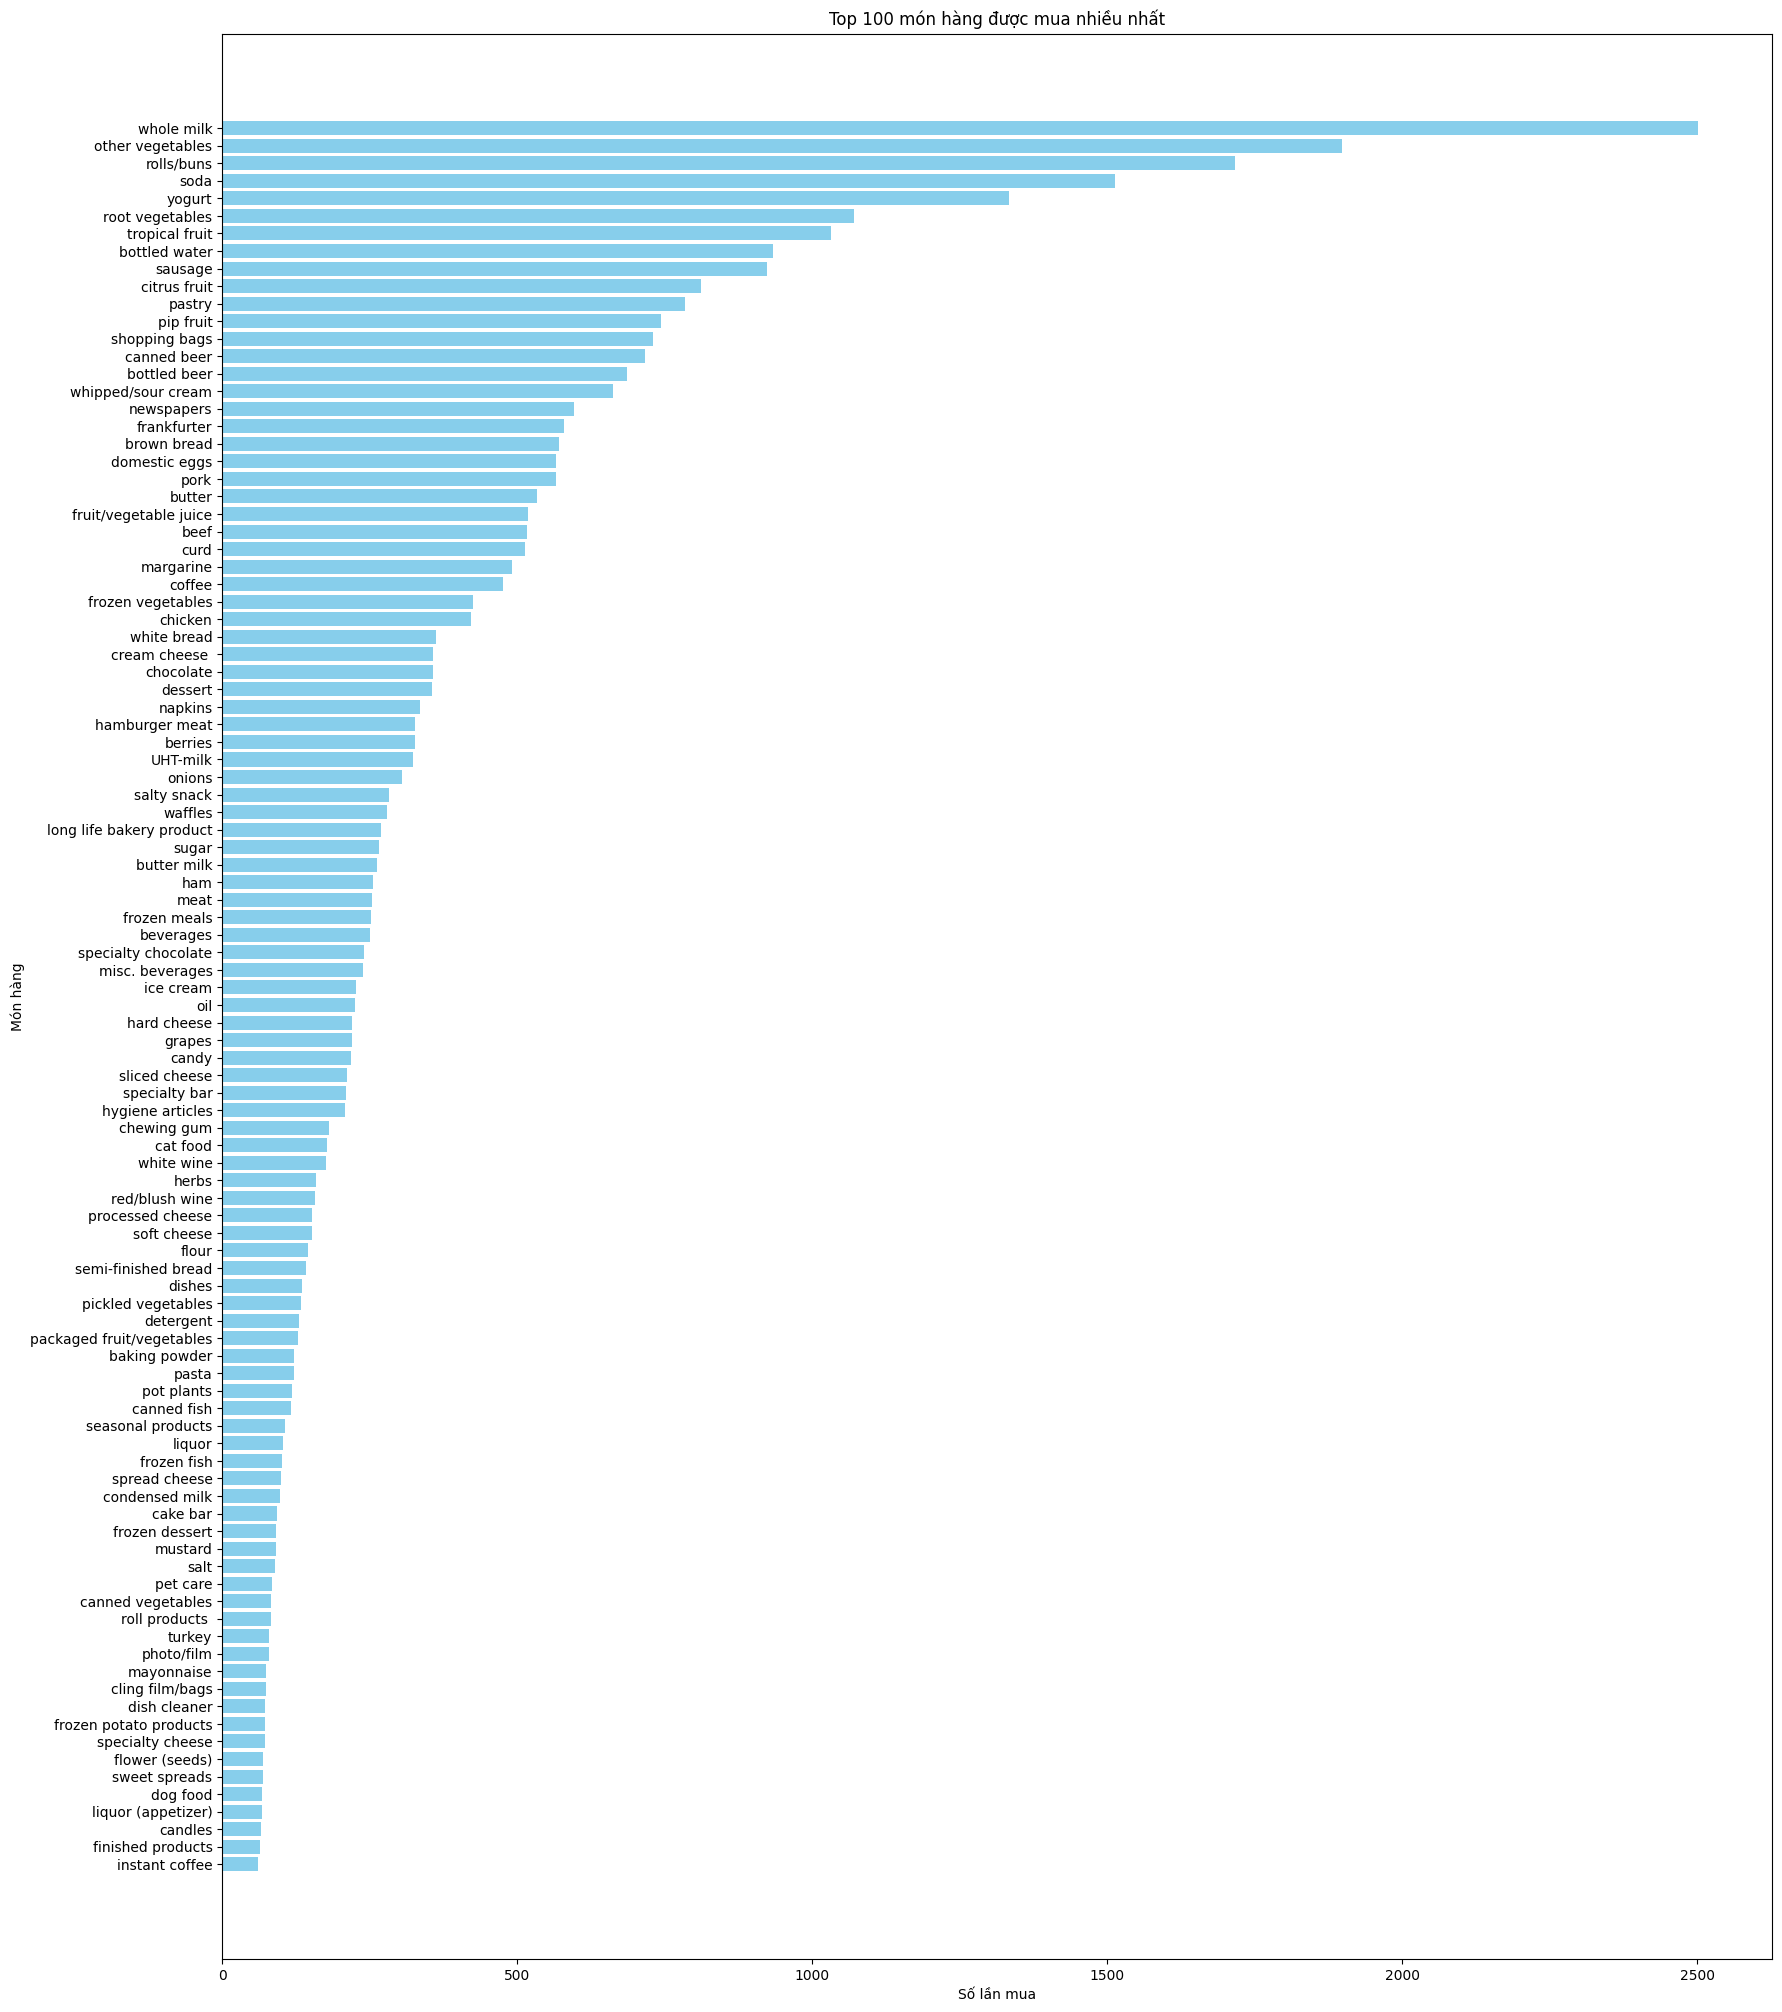

In [ ]:
visualizationData_(dataf2)

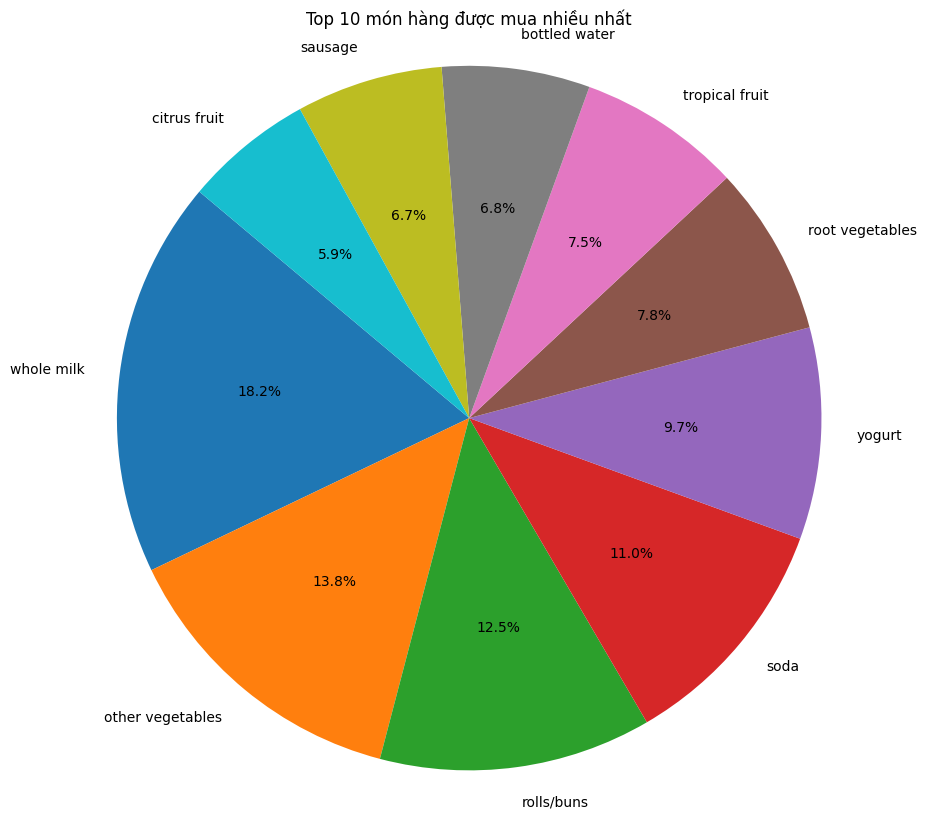

In [ ]:
visualizationData(dataf2)

#F3

In [ ]:
def f3(path):

  # Nhóm các giao dịch theo Member_number và Date, sau đó đếm số lượng giỏ hàng cho mỗi người dùng
  basket_counts = rdd_split.map(lambda x: ((x[0], x[1]), 1)).reduceByKey(lambda a, b: a + b)

  # Đếm số lượng giỏ hàng cho mỗi người dùng
  basket_counts_per_user = basket_counts.map(lambda x: (x[0][0], 1)).reduceByKey(lambda a, b: a + b)

  # Sắp xếp giảm dần theo số lượng giỏ hàng
  sorted_basket_counts = basket_counts_per_user.sortBy(lambda x: x[1], ascending=False)

  # sorted_basket_counts.coalesce(1).saveAsTextFile("f3")

  top_100_basket = sorted_basket_counts.take(100)
  print("Top 100 người có giỏ hàng nhiều nhất")
  print("mã khách hàng: số lượng giỏ hàng")
  for item, count in top_100_basket:
      print(f"{item}: {count}")
  return top_100_basket

def visualizationDataF3(top_100_basket):

  user_ids = [user[0] for user in top_100_basket]
  basket_counts = [user[1] for user in top_100_basket]


  plt.figure(figsize=(10, 20))
  plt.bar(user_ids, basket_counts, color='skyblue')
  plt.xlabel('Mã người dùng')
  plt.ylabel('Số lượng giỏ hàng')
  plt.title('Top 100 người dùng mua nhiều giỏ hàng nhất')
  plt.xticks(rotation=90)
  plt.show()



In [ ]:
dataf3 = f3("/content/drive/MyDrive/Midterm_BigData/baskets.csv")

Top 100 người có giỏ hàng nhiều nhất
mã khách hàng: số lượng giỏ hàng
2271: 11
1379: 11
4338: 11
3737: 11
2193: 11
1574: 10
4217: 10
2524: 10
2394: 10
4864: 10
3180: 10
3872: 10
1793: 10
3915: 10
3120: 10
4376: 10
1052: 10
1908: 10
3289: 10
3082: 10
3248: 10
1410: 10
3484: 10
2625: 10
1275: 10
3593: 10
2851: 9
3221: 9
4303: 9
1566: 9
3830: 9
4683: 9
1136: 9
1169: 9
4933: 9
3050: 9
2517: 9
2990: 9
2164: 9
1991: 9
4272: 9
3402: 9
4137: 9
3361: 9
1922: 9
4364: 9
2760: 9
1827: 9
3462: 9
2294: 9
2663: 9
3090: 9
1905: 9
1878: 9
3465: 9
4941: 9
1087: 9
1466: 9
1998: 9
2960: 9
4437: 9
2070: 9
3122: 9
4656: 9
2758: 9
4494: 9
1932: 9
2440: 9
2632: 9
4190: 9
1654: 9
3308: 9
4526: 9
4695: 9
4721: 8
4453: 8
1013: 8
4297: 8
4645: 8
3137: 8
3517: 8
2706: 8
1889: 8
4694: 8
2868: 8
3657: 8
4667: 8
1235: 8
2511: 8
2298: 8
4875: 8
3942: 8
1190: 8
3812: 8
2011: 8
4019: 8
3663: 8
4455: 8
1979: 8
2014: 8


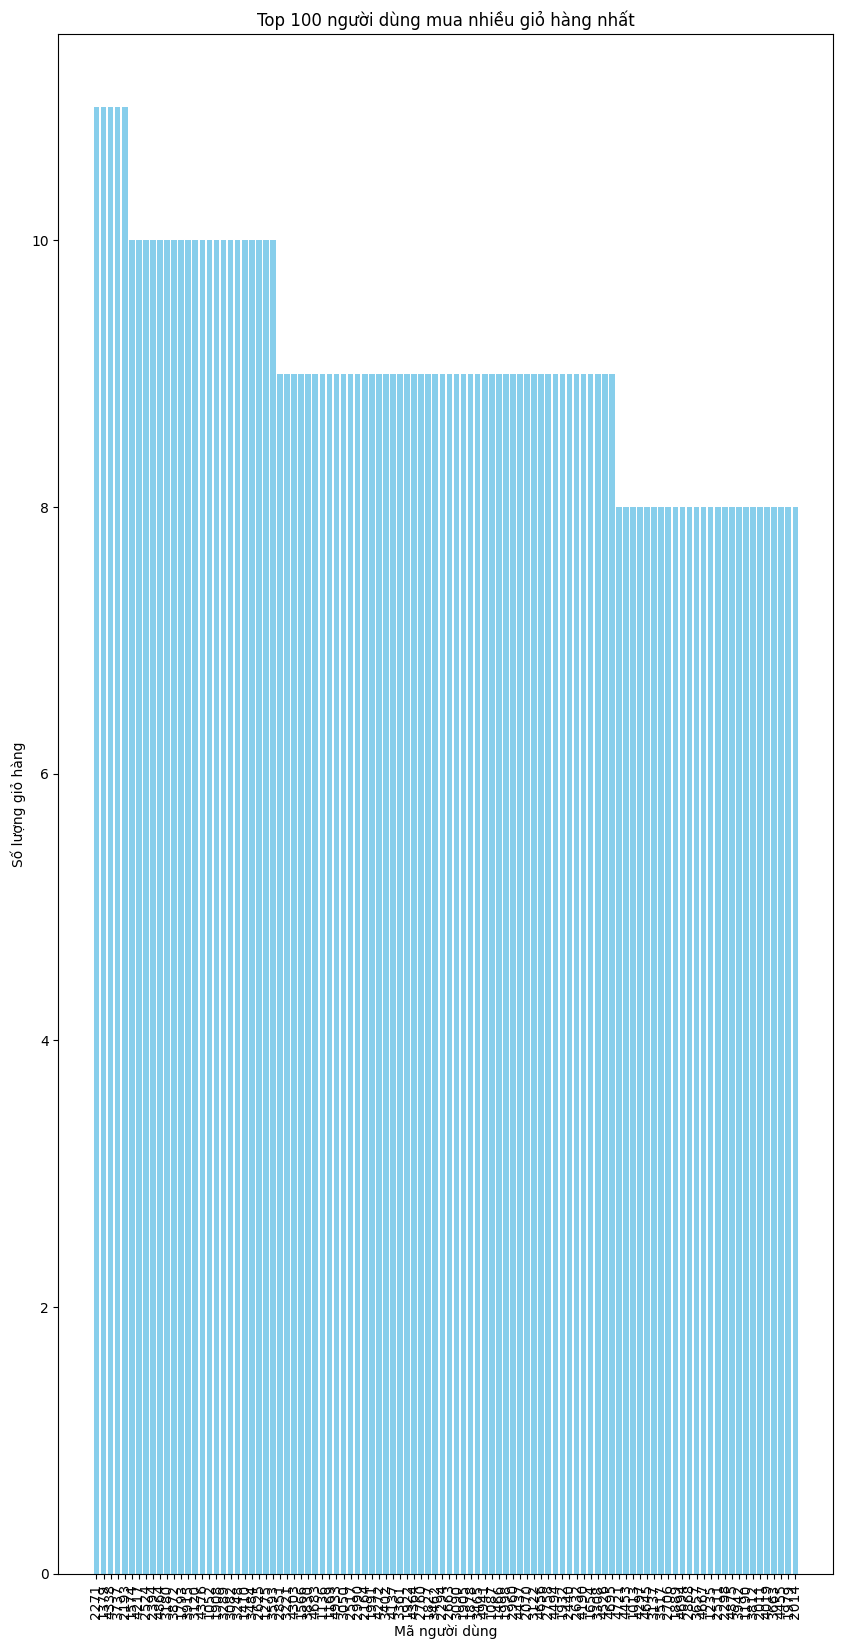

In [ ]:
visualizationDataF3(dataf3)

#F4.1

In [ ]:
def f4(path):
  def f4_1(path):

    # Nhóm các giao dịch theo Member_number và itemDescription,
    unique_items_user_temp = rdd_split.map(lambda x: ((x[0], x[2]), 1)).distinct()

    unique_items_user = unique_items_user_temp.map(lambda x: (x[0][0], 1)).reduceByKey(lambda a, b: a + b)

    # Tìm người dùng mua nhiều món hàng phân biệt nhất
    mostUniquie_items_user = unique_items_user.max(lambda x: x[1])

    # In ra kết quả
    print("Người dùng mua nhiều món hàng phân biệt nhất:")
    print(f"Mã người dùng: {mostUniquie_items_user[0]}")
    print(f"Số lượng món hàng phân biệt: {mostUniquie_items_user[1]}")
    print("-----------------------------------------------------")
    return mostUniquie_items_user

  def f4_2(path):

    unique_users_per_item_temp = rdd_split.map(lambda x: ((x[2], x[0]), 1)).distinct()

    unique_users_per_item = unique_users_per_item_temp.map(lambda x: (x[0][0], 1)).reduceByKey(lambda a, b: a + b)

    # Tìm món hàng được mua bởi nhiều người dùng nhất
    most_popular_item = unique_users_per_item.max(lambda x: x[1])

    # In ra kết quả
    print("Món hàng được mua bởi nhiều người dùng nhất:")
    print(f"Tên món hàng: {most_popular_item[0]}")
    print(f"Số lượng người mua: {most_popular_item[1]}")
    return most_popular_item

  most_unique_items_user = f4_1("")
  most_popular_item = f4_2("")
  return most_unique_items_user, most_popular_item



In [ ]:
most_unique_items_user, most_popular_item = f4("/content/drive/MyDrive/Midterm_BigData/baskets.csv")
# Lưu kết quả xuống folder f4
most_unique_items_user_rdd = sparkContext.parallelize([(most_unique_items_user[0], most_unique_items_user[1])])
most_unique_items_user_rdd.saveAsTextFile("f4/most_unique_items_user")

most_popular_item_rdd = sparkContext.parallelize([(most_popular_item[0], most_popular_item[1])])
most_popular_item_rdd.saveAsTextFile("f4/most_popular_item")


Người dùng mua nhiều món hàng phân biệt nhất:
Mã người dùng: 2051
Số lượng món hàng phân biệt: 26
-----------------------------------------------------
Món hàng được mua bởi nhiều người dùng nhất:
Tên món hàng: whole milk
Số lượng người mua: 1786


# QUESTION 2

In [ ]:
rdd = sparkContext.parallelize(rdd.collect())

In [ ]:
type(rdd)

pyspark.rdd.RDD

In [ ]:
from pyspark.sql import SparkSession

# Tạo SparkSession
spark = SparkSession.builder \
    .appName("Read_CSV_to_DF") \
    .getOrCreate()

# Đọc tệp CSV vào DataFrame
df = spark.read.csv("/content/drive/MyDrive/Midterm_BigData/baskets.csv", header=True, inferSchema=True)

# Hiển thị DataFrame
df.count()

38765

#QUESTION 2.1

In [ ]:
from pyspark.sql.functions import collect_set, date_format
from pyspark.sql.window import Window
from pyspark.sql import functions as F

basket_df = df.groupBy("Member_number", "Date").agg(collect_set("itemDescription").alias("Basket"))

basket_df = basket_df.withColumn("Date", F.to_date("Date", "dd/MM/yyyy"))
sorted_basket_df_temp = basket_df.orderBy("Date")

# Hiển thị DataFrame và định dạng cột "Date" thành dd/MM/yyyy
sorted_basket_df = sorted_basket_df_temp.select("Member_number", date_format("Date", "dd/MM/yyyy").alias("Date"), "Basket")
sorted_basket_df.limit(100).show(truncate=False)

+-------------+----------+-------------------------------------------------+
|Member_number|Date      |Basket                                           |
+-------------+----------+-------------------------------------------------+
|2727         |01/01/2014|[hamburger meat, frozen potato products]         |
|1249         |01/01/2014|[citrus fruit, coffee]                           |
|1659         |01/01/2014|[specialty chocolate, frozen vegetables]         |
|3681         |01/01/2014|[dishes, onions, whipped/sour cream]             |
|2974         |01/01/2014|[bottled water, berries, whipped/sour cream]     |
|3942         |01/01/2014|[yogurt, Instant food products, other vegetables]|
|2237         |01/01/2014|[Instant food products, bottled water]           |
|2610         |01/01/2014|[domestic eggs, bottled beer, hamburger meat]    |
|4260         |01/01/2014|[soda, brown bread]                              |
|3956         |01/01/2014|[yogurt, shopping bags, waffles, chocolate]      |

In [ ]:
from pyspark.sql.functions import col, concat_ws
# Lưu DataFrame xuống thư mục baskets dưới dạng tệp CSV
sorted_basket_df_temp = sorted_basket_df
df_with_string_column = sorted_basket_df_temp.withColumn("basket", concat_ws(",", col("Basket")))

In [ ]:
df_with_string_column  = df_with_string_column.coalesce(1)
# Lưu DataFrame xuống thư mục baskets dưới dạng tệp CSV
df_with_string_column.write.csv("baskets", mode="overwrite", header=True)

#2.2

In [ ]:
import pandas as pd
# Tính số lượng giỏ hàng được mua trong một ngày (date)

sorted_basket_df__ = sorted_basket_df.withColumn("Date", F.to_date("Date", "dd/MM/yyyy"))
basket_count_per_day = sorted_basket_df__.groupBy("Date").count().orderBy("Date")

basket_count_per_day.show(truncate=False)
# Chuyển đổi kết quả thành pandas DataFrame để vẽ biểu đồ
basket_count_per_day_pd = basket_count_per_day.toPandas()

+----------+-----+
|Date      |count|
+----------+-----+
|2014-01-01|21   |
|2014-01-02|29   |
|2014-01-03|24   |
|2014-01-04|28   |
|2014-01-05|20   |
|2014-01-06|13   |
|2014-01-07|16   |
|2014-01-08|19   |
|2014-01-09|28   |
|2014-01-10|23   |
|2014-01-11|15   |
|2014-01-12|18   |
|2014-01-13|20   |
|2014-01-14|24   |
|2014-01-15|13   |
|2014-01-16|18   |
|2014-01-17|20   |
|2014-01-18|22   |
|2014-01-19|23   |
|2014-01-20|24   |
+----------+-----+
only showing top 20 rows



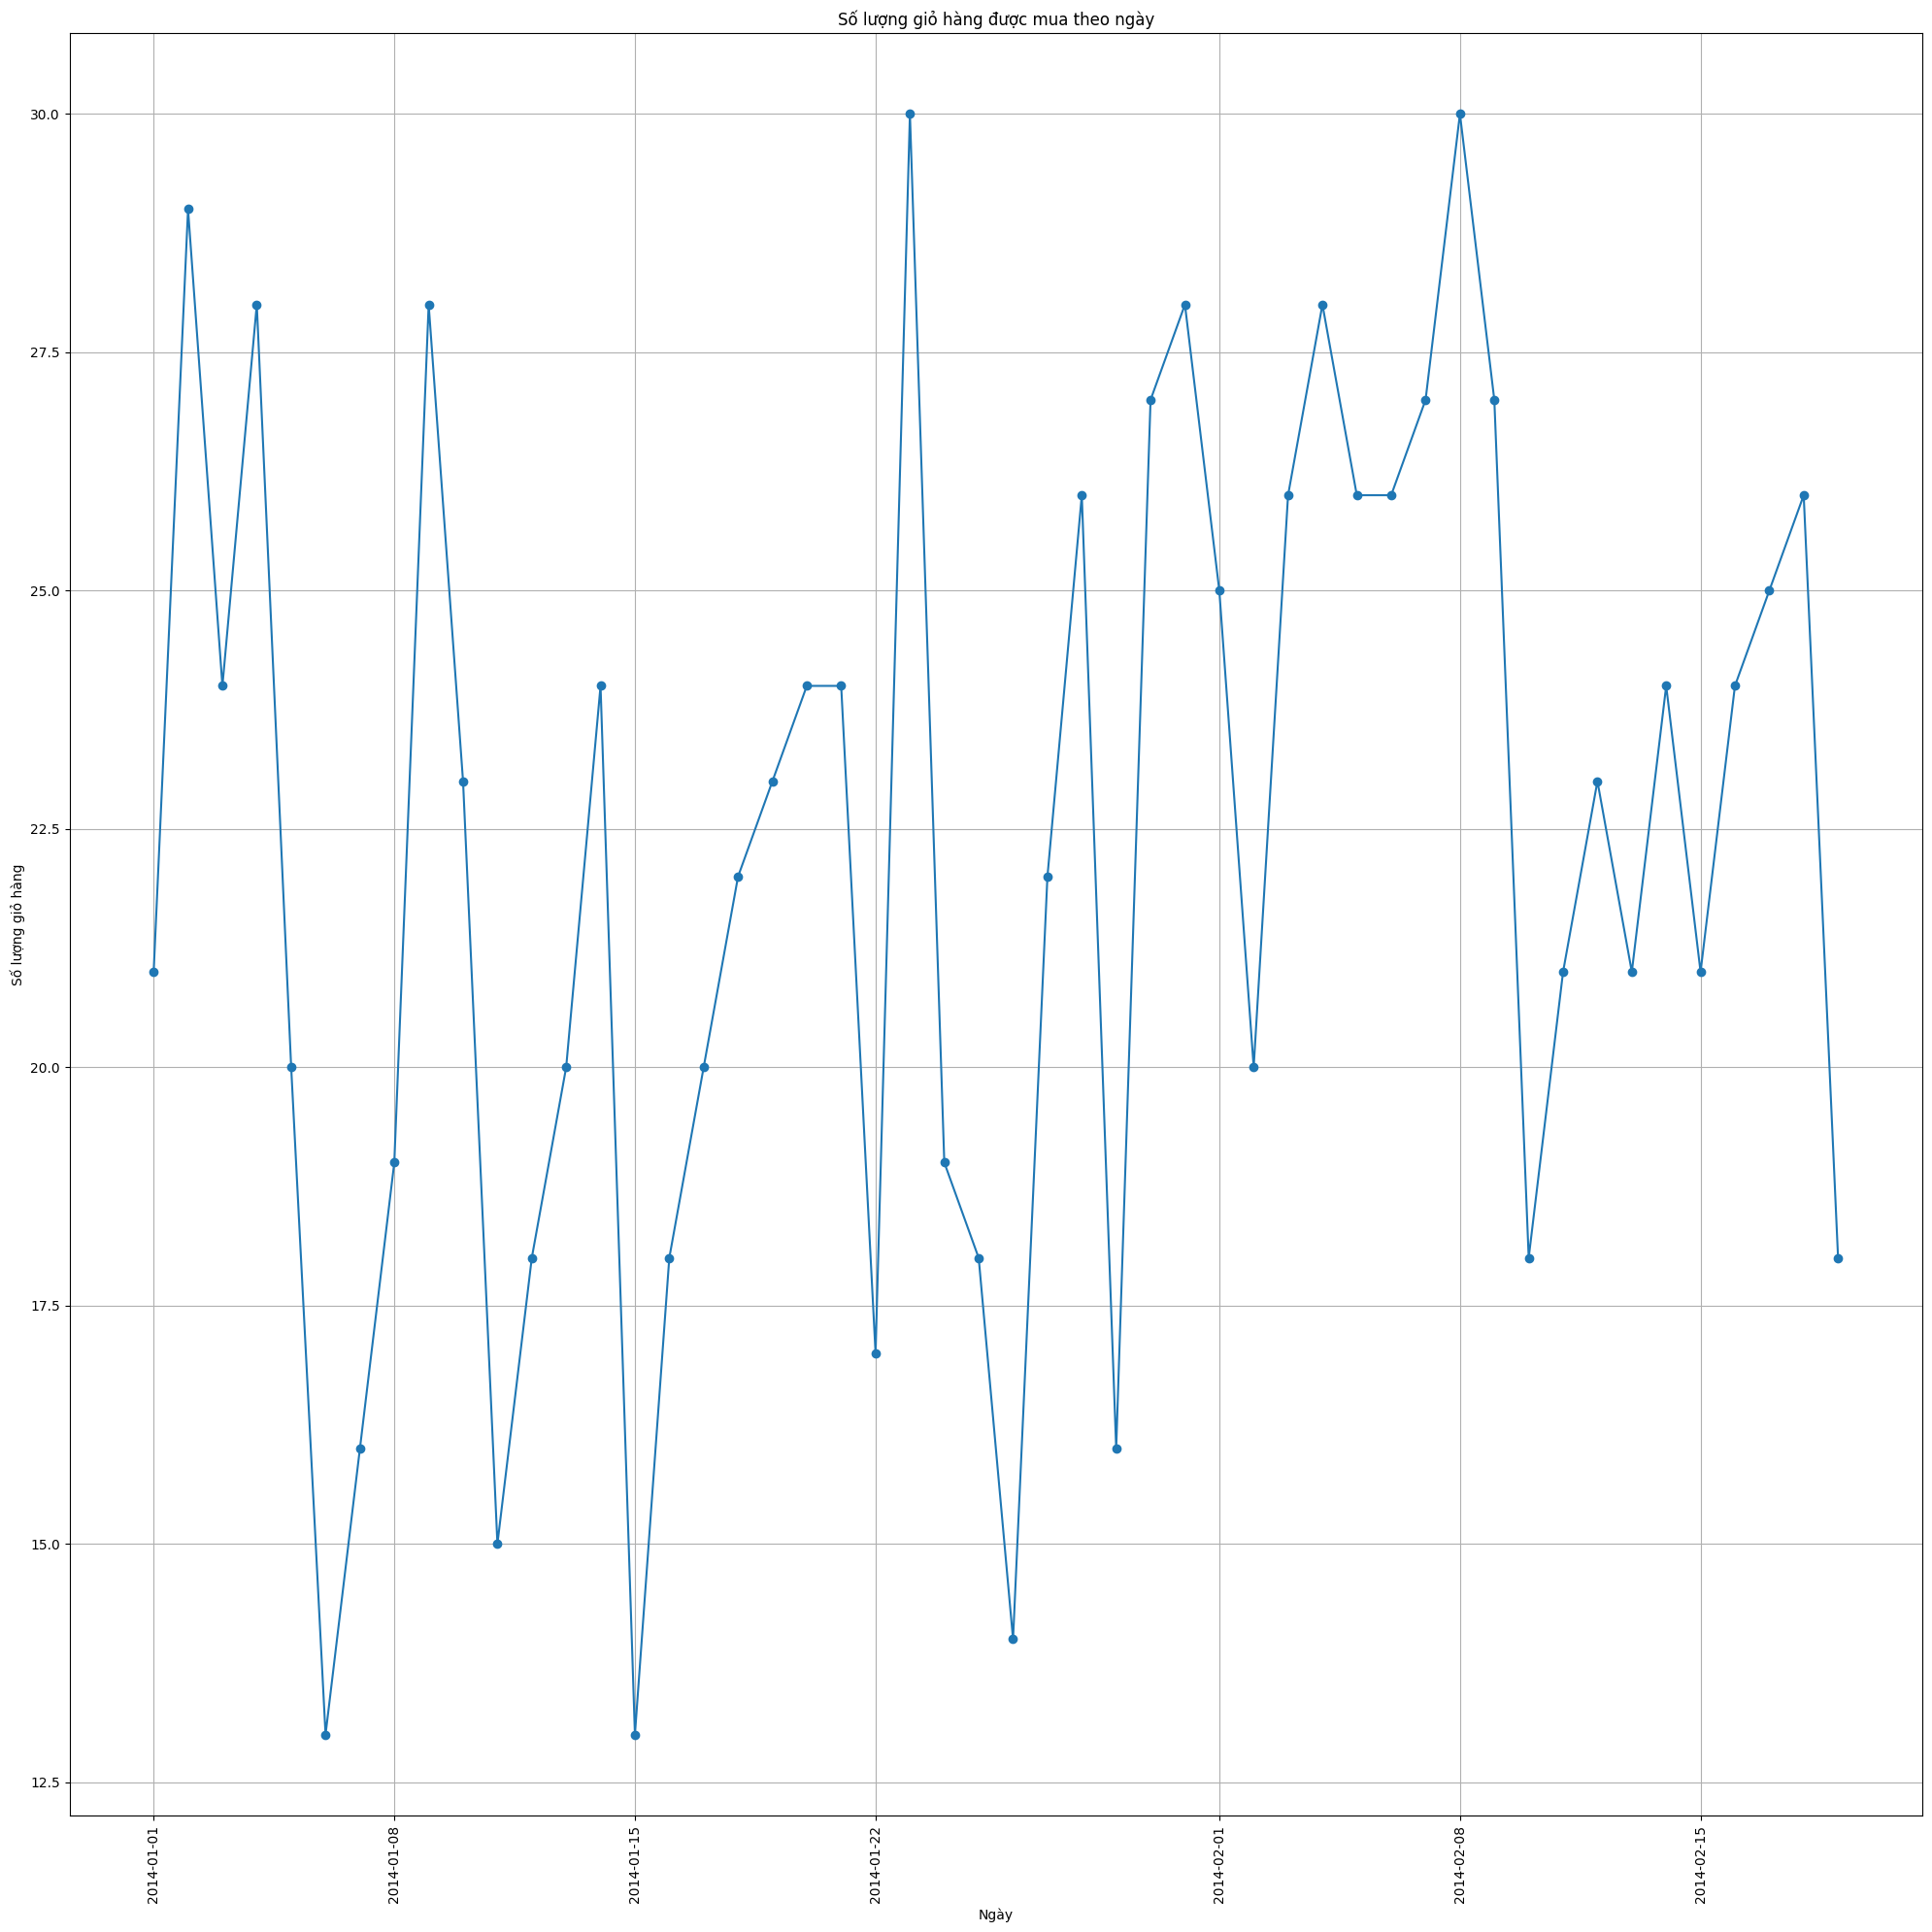

In [ ]:
plt.figure(figsize=(20, 20))
plt.plot(basket_count_per_day_pd["Date"].head(50), basket_count_per_day_pd["count"].head(50), marker='o', linestyle='-')
plt.title("Số lượng giỏ hàng được mua theo ngày")
plt.xlabel("Ngày")
plt.ylabel("Số lượng giỏ hàng")
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()


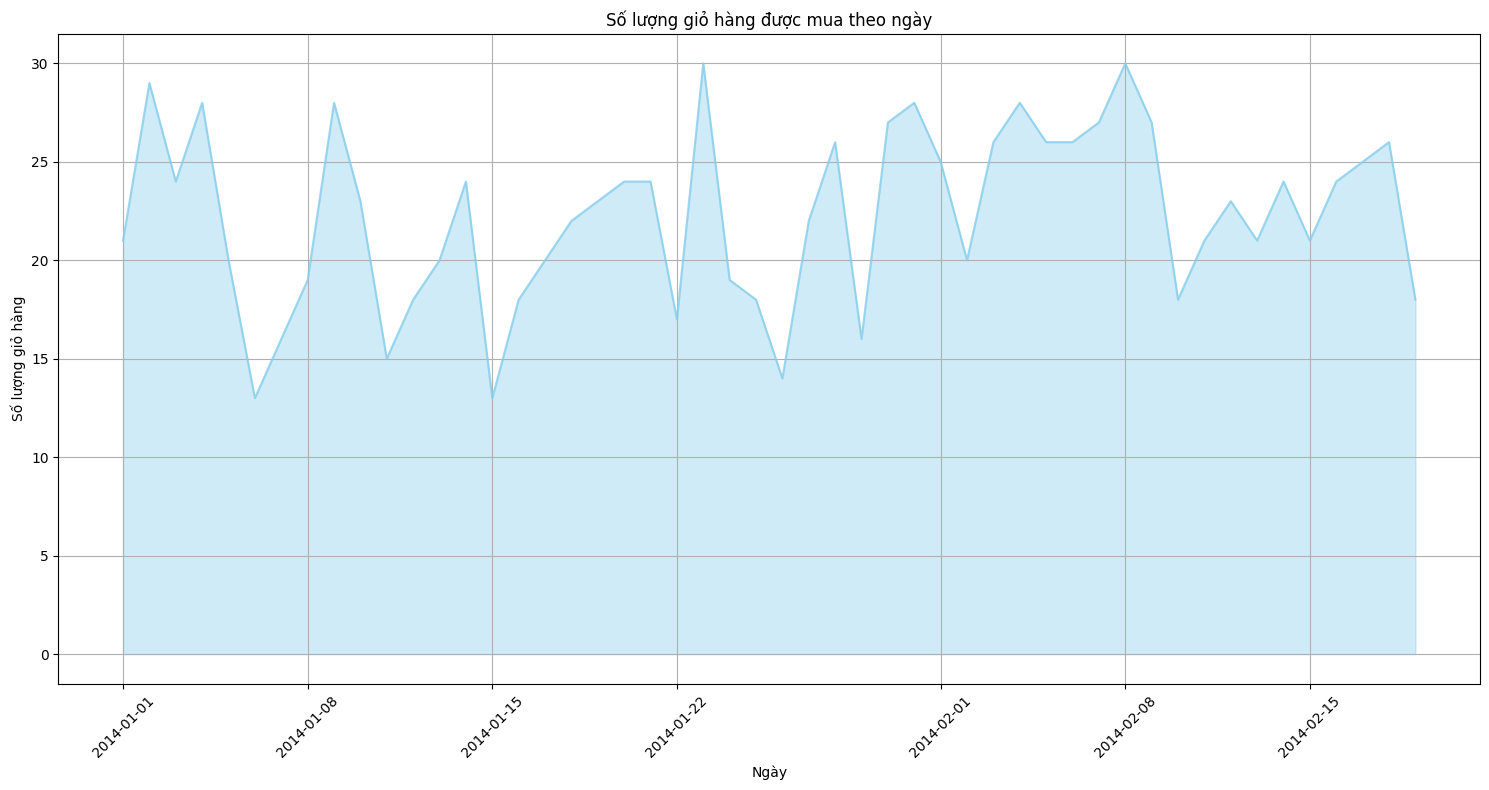

In [ ]:
plt.figure(figsize=(15, 8))
plt.fill_between(basket_count_per_day_pd["Date"].head(50), basket_count_per_day_pd["count"].head(50), color='skyblue', alpha=0.4)
plt.plot(basket_count_per_day_pd["Date"].head(50), basket_count_per_day_pd["count"].head(50), color='skyblue', alpha=0.8)
plt.title("Số lượng giỏ hàng được mua theo ngày")
plt.xlabel("Ngày")
plt.ylabel("Số lượng giỏ hàng")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


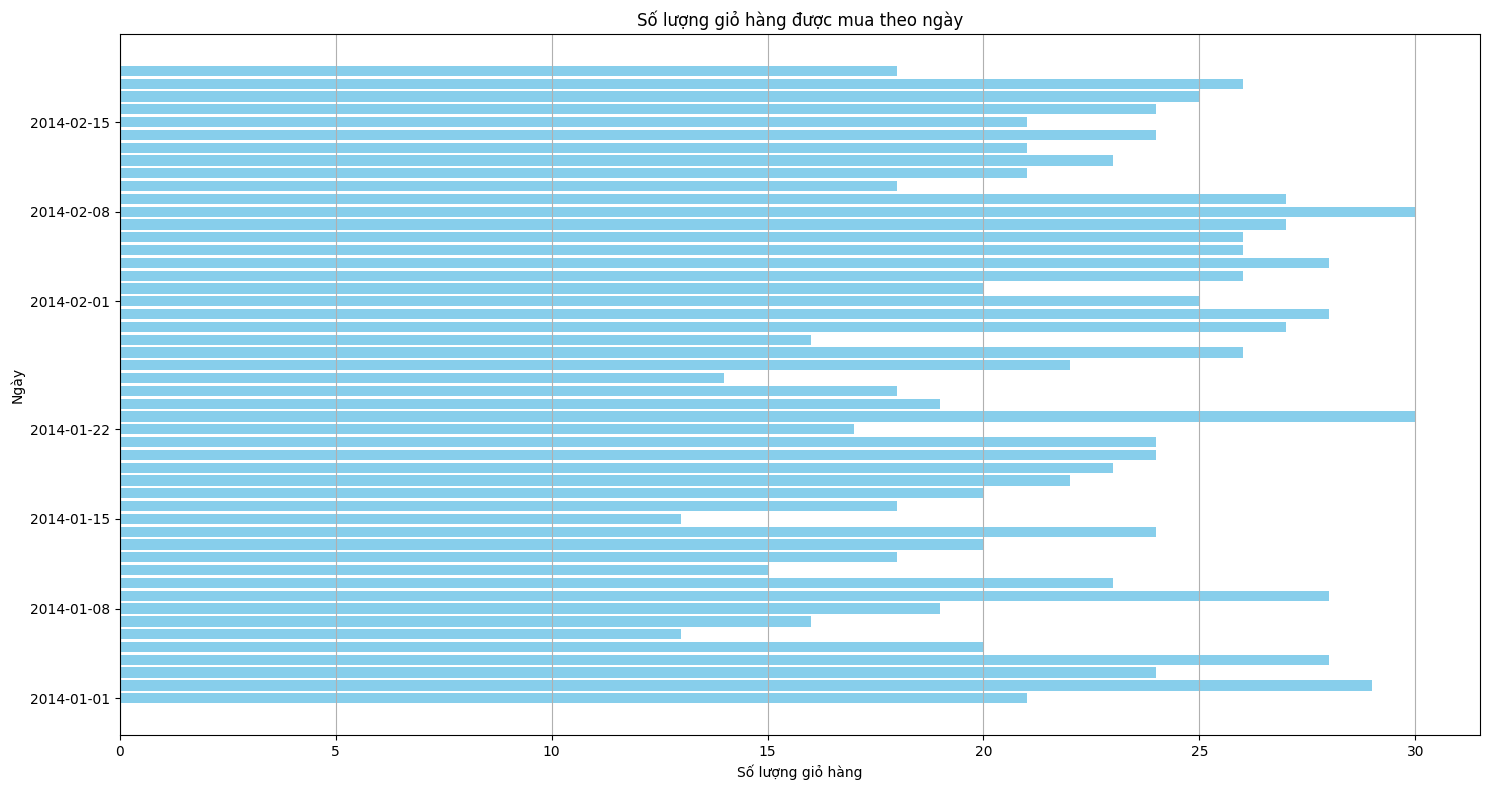

In [ ]:
plt.figure(figsize=(15, 8))
plt.barh(basket_count_per_day_pd["Date"].head(50), basket_count_per_day_pd["count"].head(50), color='skyblue')
plt.title("Số lượng giỏ hàng được mua theo ngày")
plt.xlabel("Số lượng giỏ hàng")
plt.ylabel("Ngày")
plt.grid(axis='x')
plt.tight_layout()
plt.show()


#Save folder

In [ ]:
from pyspark.sql.functions import concat, lit

# Tạo một cột mới có tên 'Member_number_Date' ghép từ 'Member_number' và 'Date'
merged_column = concat(col("Member_number"), lit("_"), col("Date")).alias("Member_number_Date")

# Thêm cột mới vào DataFrame
merged_df = df_with_string_column.withColumn("Member_number_Date", merged_column)
# Loại bỏ các cột 'Member_number' và 'Date' từ DataFrame
final_df = merged_df.drop("Member_number", "Date")
# Hiển thị kết quả
final_df_coalesced  = final_df.coalesce(1)
final_df.show(truncate=False)

+---------------------------------------------+------------------+
|basket                                       |Member_number_Date|
+---------------------------------------------+------------------+
|citrus fruit,coffee                          |1249_01/01/2014   |
|hamburger meat,frozen potato products        |2727_01/01/2014   |
|specialty chocolate,frozen vegetables        |1659_01/01/2014   |
|dishes,onions,whipped/sour cream             |3681_01/01/2014   |
|bottled water,berries,whipped/sour cream     |2974_01/01/2014   |
|yogurt,Instant food products,other vegetables|3942_01/01/2014   |
|Instant food products,bottled water          |2237_01/01/2014   |
|domestic eggs,bottled beer,hamburger meat    |2610_01/01/2014   |
|soda,brown bread                             |4260_01/01/2014   |
|yogurt,shopping bags,waffles,chocolate       |3956_01/01/2014   |
|candles,hamburger meat                       |1789_01/01/2014   |
|tropical fruit,other vegetables              |1922_01/01/2014

In [ ]:
# Lưu DataFrame xuống thư mục baskets dưới dạng tệp CSV
final_df_coalesced.write.csv("baskets", mode="overwrite", header=True)

In [ ]:
final_df.count()

14963

In [ ]:
sparkContext.stop()
spark.stop()

#QUESTION 3

In [ ]:
  # chủ động thay đổi đường dẫn khi chạy lại file
  path = '/content/part-00000-1025c180-87b8-4c64-bfe6-20806b95273c-c000.csv'
  s = 0.01
  num_buckets = 14963
  c = 0.02

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import hash,explode,expr, collect_set, col, split, array_contains,abs, collect_list, struct, udf,sum as spark_sum, when, count, coalesce
from itertools import combinations
from pyspark.sql.types import IntegerType

In [ ]:
class PCY:
    def __init__(self, file_path, s=3, c=0.5, num_buckets = 10):
        self.file_path = file_path
        self.s = s
        self.c = c
        self.n = 14963
        self.num_buckets = num_buckets
        self.spark = SparkSession.builder \
            .appName("PCY_Q3") \
            .getOrCreate()

    def read_data_from_file(self):
        # Load data from file
        data = self.spark.read.option("header", "true").csv(self.file_path)

        baskets = data.withColumn("items", split(col("basket"), ",")) \
                      .withColumn("items", explode(col("items"))) \
                      .groupBy("Member_number_Date") \
                      .agg(collect_set("items").alias("items"))
        #print(baskets.take(10))
        return baskets

    # PASS 1
    def get_single_items(self, baskets):
        exploded_baskets = baskets.withColumn("item", explode(col("items")))
        single_items = exploded_baskets.groupBy("item").count()
        # Sắp xếp DataFrame theo số lượng từ thấp đến cao
        # sorted_single_items = single_items.orderBy("count")
        # Tính tỷ lệ của count với num_buckets và thêm nó dưới dạng cột mới
        single_items_with_ratio = single_items.withColumn("support", col("count") / self.n)
        return single_items_with_ratio

    def get_single_items_(self, single_items):
        data_singgle = single_items.filter(col("support") >= self.s) \
                      .select("item", "count")
        print("Single frequent item:")
        data_singgle.show(truncate=False)
        return data_singgle


    def get_candidate_items(self, frequent_items):
        list_items = frequent_items.select("item").rdd.flatMap(lambda x: x).collect()
        # Tạo tất cả các cặp có thể có từ danh sách các mặt hàng
        pairs = combinations(list_items, 2)
        # Chuyển các cặp thành DataFrame
        pair_data = self.spark.createDataFrame(pairs, ["item1", "item2"])
        print("Candidate items: ")
        pair_data.show(truncate=False)
        return pair_data


    def frequent_pairs(self, basket,candidate_items):
      # Đếm số lần xuất hiện của mỗi cặp ứng viên trong giỏ hàng
      pair_counts = basket.alias("b").join(candidate_items.alias("c"),
                                              (array_contains(col("b.items"), col("c.item1"))) &
                                              (array_contains(col("b.items"), col("c.item2")))) \
                                      .groupBy("c.item1", "c.item2") \
                                      .count()

      pair_counts = pair_counts.withColumn("support", col("count") / self.n)
      pcy_frequent_pairs =  pair_counts.filter(col("support") >= self.s) \
                    .select("item1", "item2", "count")
      print("frequent_pairs: ")
      pcy_frequent_pairs.show(truncate=False)
      return pcy_frequent_pairs

    # PASS 2
    def pcy_frequent_pairs(self, frequent_pairs):
        pcy_frequent_pairs =  frequent_pairs

        # Áp dụng hàm băm cho cả cột item1 và item2
        hashed_df = pcy_frequent_pairs.withColumn("h1", hash("item1")).withColumn("h2", hash("item2"))

        # Compute hash_final = abs(h1 * h2) % 10
        hashed_final_df = hashed_df.withColumn("Bucketno", abs((col("h1") * col("h2")) % 10))
        hashed_final_df = hashed_final_df.drop("h1", "h2")
        # Nhóm theo cột 'hash_final' và thu thập các cặp (item1, item2) và đếm cho mỗi nhóm
        grouped_df = hashed_final_df.groupBy("Bucketno").agg(collect_list(struct("item1", "item2", "count")).alias("pairs"))
        # Thêm một cột mới 'count_total' bằng cách tính tổng số lượng trong cấu trúc
        grouped_df = grouped_df.withColumn("count_total", expr("aggregate(pairs, 0, (acc, x) -> acc + CAST(x.count AS INT))"))
        # Thêm một cột mới 'vector_bit' dựa trên điều kiện count_total > self.s
        grouped_df = grouped_df.withColumn("support", col("count_total") / self.n)
        grouped_df = grouped_df.withColumn("vector_bit", when(col("support") >= self.s, 1).otherwise(0))

        # Chọn và sắp xếp lại các cột theo yêu cầu
        grouped_df = grouped_df.select("vector_bit","Bucketno", "count_total", "pairs")
        # grouped_df.show()
        # print(grouped_df.count())
        # Filter rows where vector_bit > 1
        filtered_df = grouped_df.filter(col("vector_bit") == 1)
        # print(filtered_df.count())
        # Show the resulting DataFrame
        filtered_df.show(truncate=False)
        # Select the individual items from the exploded struct

        grouped_df_temp = filtered_df.select(explode("pairs").alias("pair"))
        grouped_df_temp.show(truncate=False)

        # Tách struct thành các cột riêng biệt
        df_split = grouped_df_temp.select(col("pair.item1").alias("item1"),
                            col("pair.item2").alias("item2"),
                            col("pair.count").alias("count"))

        # Hiển thị kết quả
        print("pcy_frequent_paire: ")
        df_split.show(truncate=False)
        return df_split


    def association_rules(self, df_baskets, df_frequent_paire):
        exploded_df1 = df_baskets.select("Member_number_Date", explode("items").alias("item1"))
        count_df1 = exploded_df1.groupBy("item1").count().withColumnRenamed("count", "item1_count")

        exploded_df2 = df_baskets.select("Member_number_Date", explode("items").alias("item2"))
        count_df2 = exploded_df2.groupBy("item2").count().withColumnRenamed("count", "item2_count")

        candidate_df = df_frequent_paire.withColumnRenamed("count", "item1_item2_count")
        result_df = count_df1.join(candidate_df, count_df1["item1"] == candidate_df["item1"], "inner") \
            .join(count_df2, count_df2["item2"] == candidate_df["item2"], "inner") \
            .select(count_df1["item1"],count_df2["item2"],  "item1_count",  "item2_count", "item1_item2_count")

        # Tạo cột mới item1->item2_confident
        result_df = result_df.withColumn("item1->item2_confident", col("item1_item2_count") / col("item1_count"))

        # Tạo cột mới item2->item1_confident
        result_df = result_df.withColumn("item2->item1_confident", col("item1_item2_count") / col("item2_count"))
        r1 = result_df.select("item1","item2","item1->item2_confident")
        r1 = r1.withColumnRenamed("item1", "antecedents").withColumnRenamed("item2", "consequents").withColumnRenamed("item1->item2_confident", "confident")
        r2 = result_df.select("item2","item1","item2->item1_confident")
        r2 = r2.withColumnRenamed("item2", "antecedents").withColumnRenamed("item1", "consequents").withColumnRenamed("item2->item1_confident", "confident")
        r = r1.union(r2)

        # Hiển thị kết quả
        r.show()
        r = r.filter(col("confident") >= self.c)
        # Hiển thị kết quả
        print("pcy_association_rules: ")
        r.show(truncate=False)

        return r


    def run(self):
        # Load data and preprocess
        baskets = self.read_data_from_file()

        single_items = self.get_single_items(baskets)
        single_items_ = self.get_single_items_(single_items)
        print(single_items_.count())
        candidate_items = self.get_candidate_items(single_items_)
        frequent_pairs = self.frequent_pairs(baskets,candidate_items)
        pcy_frequent_pairs = self.pcy_frequent_pairs(frequent_pairs)

        # KHI GHI VÀO CSV
        pcy_frequent_pairs_CSV  = pcy_frequent_pairs.select("item1", "item2")
        pcy_frequent_pairs_CSV_  = pcy_frequent_pairs_CSV.coalesce(1)
        # Lưu DataFrame xuống thư mục baskets dưới dạng tệp CSV
        pcy_frequent_pairs_CSV_.write.csv("pcy_frequent_pairs.csv", mode="overwrite", header=True)


        association_rules = self.association_rules(baskets,pcy_frequent_pairs)
        association_rules_csv  = association_rules.coalesce(1)
        # Lưu DataFrame xuống thư mục baskets dưới dạng tệp CSV
        association_rules_csv.write.csv("pcy_association_rules.csv", mode="overwrite", header=True)

        self.spark.stop()

In [ ]:
# Example usage
pcy = PCY(path, s, c, num_buckets)
pcy.run()

Single frequent item:
+------------------------+-----+
|item                    |count|
+------------------------+-----+
|beverages               |248  |
|red/blush wine          |157  |
|cat food                |177  |
|napkins                 |331  |
|meat                    |252  |
|frozen vegetables       |419  |
|white wine              |175  |
|frankfurter             |565  |
|cream cheese            |314  |
|hygiene articles        |205  |
|long life bakery product|268  |
|whipped/sour cream      |654  |
|yogurt                  |1285 |
|canned beer             |702  |
|soft cheese             |150  |
|tropical fruit          |1014 |
|curd                    |504  |
|grapes                  |216  |
|ham                     |256  |
|candy                   |215  |
+------------------------+-----+
only showing top 20 rows

64
Candidate items: 
+---------+------------------------+
|item1    |item2                   |
+---------+------------------------+
|beverages|red/blush wine   

In [ ]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

In [ ]:
!jupyter nbconvert --to PDF "/content/drive/MyDrive/Midterm_BigData/source.ipynb"